In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, json
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr, spearmanr
from matplotlib.colors import LogNorm

from functools import partial
from multiprocessing import Pool

In [215]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [41]:
files = glob.glob('data_temp/FOS_250_complete_info/*')
pds = []
for file in files:
    pds.append(pd.read_csv(file, sep='\t', header=None, index_col=0))
data = pd.concat(pds).fillna(0)
data.columns = ['birth', 'cit_list', 'hindex', 'total_cits', 'papers', 'max_ws', 'max_colabs', 'colab_cit_list', 'w_fos', 'fos']
data.head()

,birth,cit_list,hindex,total_cits,papers,max_ws,max_colabs,colab_cit_list,w_fos,fos
0,,,,,,,,,,
0,1995,"[0, 0, 0, 0, 0, 0, 0, 8.0, 10.0, 0, 0, 27.0, 1...","(15, 11, 9)",774.0,38,0.779070,0.710526,"[0, 0, 0, 0, 0, 0, 0, 11, 12, 13, 15, 2, 20, 2...","{""127313418"": 0.3997965768799102, ""86803240"": ...",86803240
1,1970,"[14.0, 31.0, 84.0, 155.0, 4.0, 54.0, 21.0, 96....","(17, 14, 11)",1681.0,20,0.958953,0.850000,"[14, 155, 21, 96, 29, 53, 304, 31, 42, 82, 53,...","{""71924100"": 13.300201286618753, ""86803240"": 4...",71924100
2,2008,"[0, 0, 0, 0, 3.0, 15.0, 127.0, 46.0, 86.0, 6.0...","(17, 14, 11)",1083.0,28,0.605725,0.428571,"[0, 0, 127, 135, 15, 28, 33, 44, 46, 52, 86, 90]","{""144133560"": 0.25, ""185592680"": 21.2193093634...",185592680
3,2007,"[0, 39.0, 13.0, 0, 0, 1.0, 0, 2.0, 0, 11.0, 28...","(23, 16, 13)",2885.0,74,0.688042,0.229730,"[0, 0, 122, 131, 856, 185, 0, 3, 3, 47, 56, 24...","{""33923547"": 7.85905303030303, ""41008148"": 13....",86803240
4,1976,"[3.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","(5, 3, 3)",223.0,37,0.672646,0.189189,"[0, 0, 0, 0, 146, 1, 3]","{""142362112"": 0.3047619047619048, ""121332964"":...",185592680


In [4]:
header = '/mnt/e/MAG/mag-2021-01-05/advanced/'
fields_infos = 'FieldsOfStudy.txt'
fos_infos = pd.read_csv(header+fields_infos, header=None, sep='\t')[[0, 1, 2]]
fos_infos.columns = ['field_id', 'rank', 'normalized_name']

In [238]:
def plot_hist(fig, group, bins, field_name, key):
    y,x = np.histogram(group[key], bins=bins)
    #y = np.cumsum(y)
    #fig.plot(x[1:], y/y[-1], label=field_name)
    bins_center = 0.5*(x[:-1]+x[1:])
    fig.plot(bins_center,y, label=field_name)
    
def basic_hist(key, bins, yscale=None, xscale=None):
    fig, ax = plt.subplots()
    for field, group in data.groupby('fos'):
        if len(group) < 1000:
            continue
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        plot_hist(ax, group, bins=bins, field_name=field_name, key=key)

    ax.legend(bbox_to_anchor=(1.05, 1))
    if yscale:
        ax.set_yscale(yscale)
    if xscale:
        ax.set_xscale(xscale)
    ax.set_title(key)
    fig.subplots_adjust(right=0.2)
    fig.tight_layout()
    fig.savefig('outputs/fos_hist_%s.pdf' % key)
    fig.show()

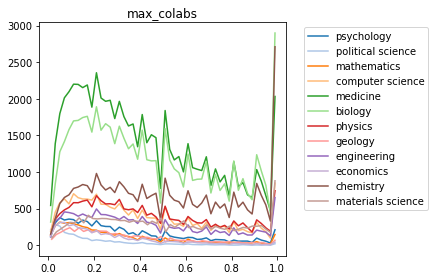

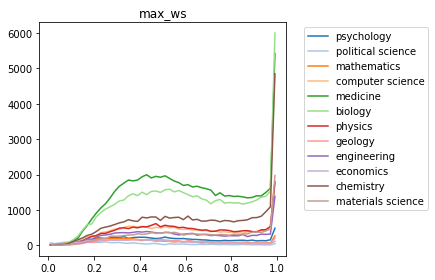

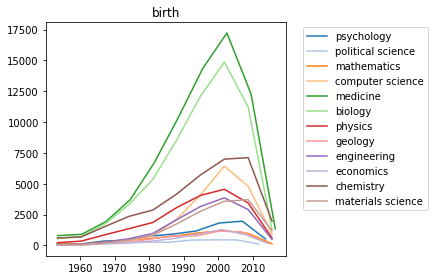

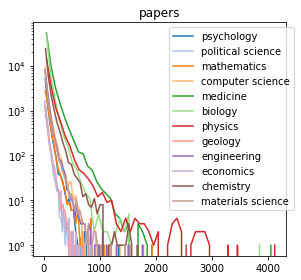

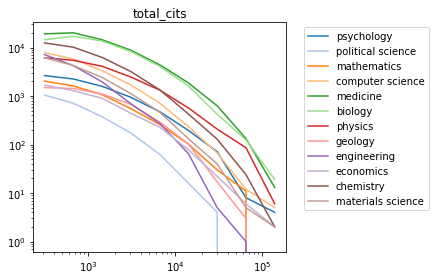

In [241]:
basic_hist('max_colabs', bins=50) # papers
basic_hist('max_ws', bins=50) # citações
basic_hist('birth', bins=10)
basic_hist('papers', bins=50, yscale='log')
xspace = np.logspace(np.log10(min(data['total_cits'])), np.log10(max(data['total_cits'])), 10)
basic_hist('total_cits', bins=xspace, yscale='log', xscale='log')

In [242]:
def _hist2d(ax, xgroup, ygroup, xspace, yspace, field_name): 
    ax.set_facecolor("black")
    im = ax.hist2d(xgroup, ygroup, bins=(xspace, yspace), cmap='inferno', norm=LogNorm()) #vmin=1,vmax=10000))
    ax.set_title("%s \nspearman=%.2f \npearson=%.2f" % (field_name, spearmanr(xgroup, ygroup)[0], pearsonr(xgroup, ygroup)[0]))
    return im
    
def hist2d(xkey, ykey, xbins, ybins, yscale=None, xscale=None):
    fig, axs = plt.subplots(figsize=(16, 6), nrows=2, ncols=6, sharex=True, sharey=True)
    i = 0
    for field, group in data.groupby('fos'):
        if len(group) < 1000:
            continue
        ax = axs[int(i/6)][i%6]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _hist2d(ax, group[xkey], group[ykey], xbins, ybins, field_name=field_name)

        if yscale:
            ax.set_yscale(yscale)
        if xscale:
            ax.set_xscale(xscale)
    
        if i%6 == 0: 
            ax.set_ylabel(ykey)
        if int(i/6) == 1:    
            ax.set_xlabel(xkey)
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
        
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_%s_%s.pdf' % (xkey, ykey))
    fig.show()

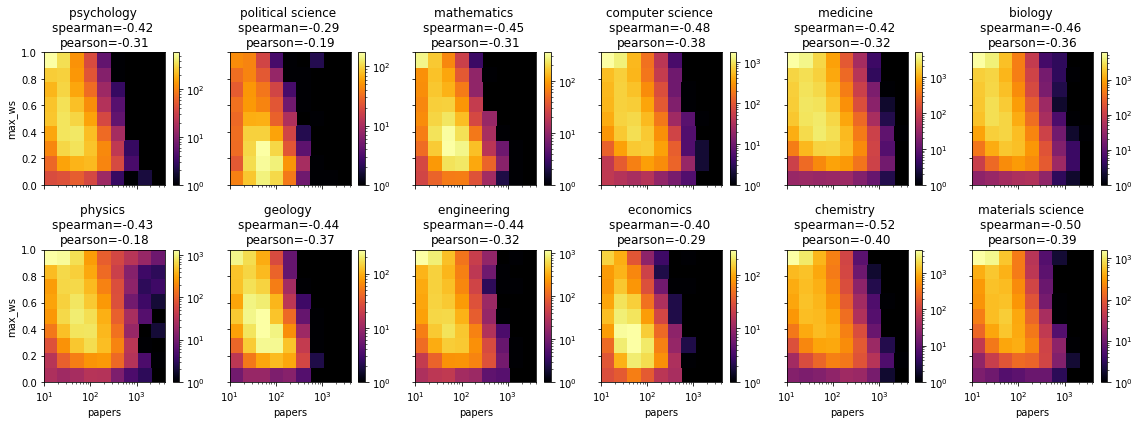

In [243]:
xbins = np.logspace(np.log10(min(data['papers'])), np.log10(max(data['papers'])+1), 10)
ybins = np.linspace(min(data['max_ws']), max(data['max_ws']), 10)
hist2d('papers', 'max_ws', xbins=xbins, ybins=ybins, xscale='log', yscale=None)

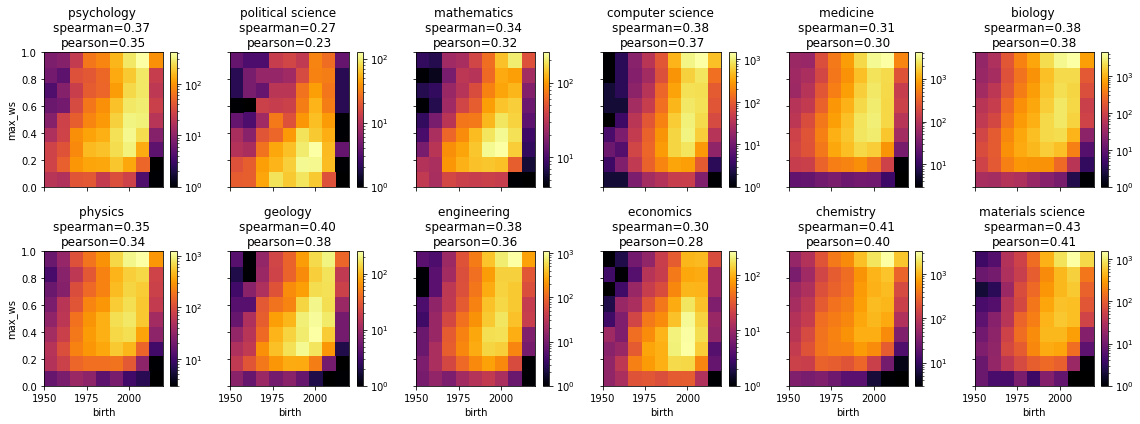

In [244]:
xbins = np.linspace(min(data['birth']), max(data['birth']), 10)
ybins = np.linspace(min(data['max_ws']), max(data['max_ws']), 10)
hist2d('birth', 'max_ws', xbins=xbins, ybins=ybins, xscale=None, yscale=None)

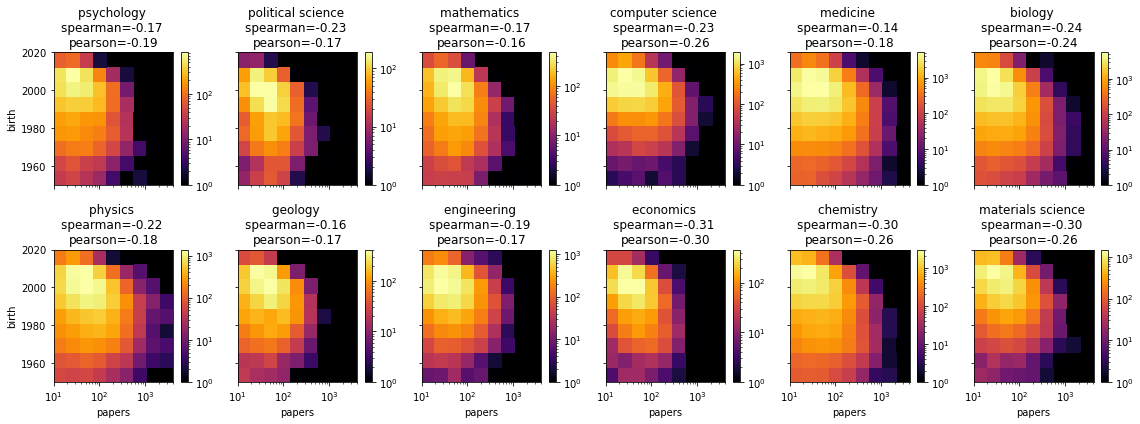

In [245]:
xbins = np.logspace(np.log10(min(data['papers'])), np.log10(max(data['papers'])+1), 10)
ybins = np.linspace(min(data['birth']), max(data['birth']), 10)
hist2d('papers', 'birth', xbins=xbins, ybins=ybins, xscale='log', yscale=None)

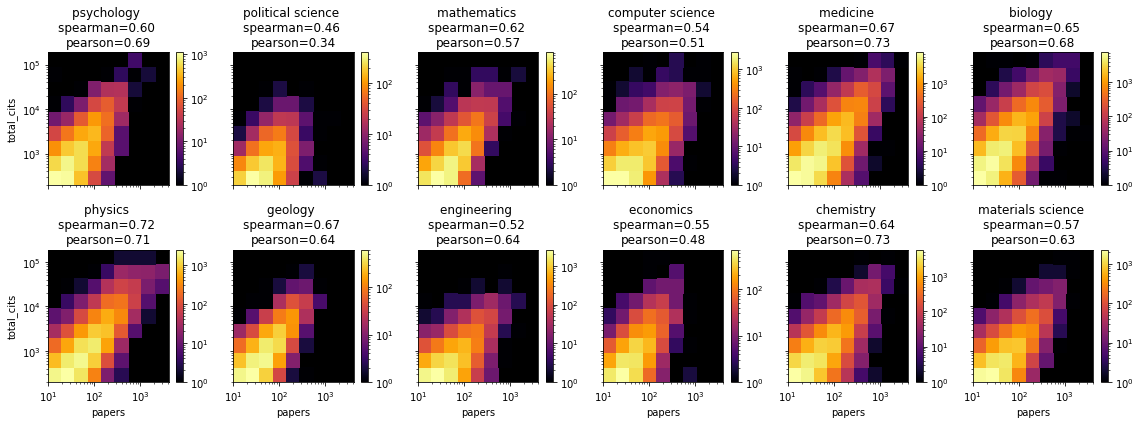

In [246]:
xbins = np.logspace(np.log10(min(data['papers'])), np.log10(max(data['papers'])+1), 10)
ybins = np.logspace(np.log10(min(data['total_cits'])), np.log10(max(data['total_cits'])+1), 10)
hist2d('papers', 'total_cits', xbins=xbins, ybins=ybins, xscale='log', yscale='log')

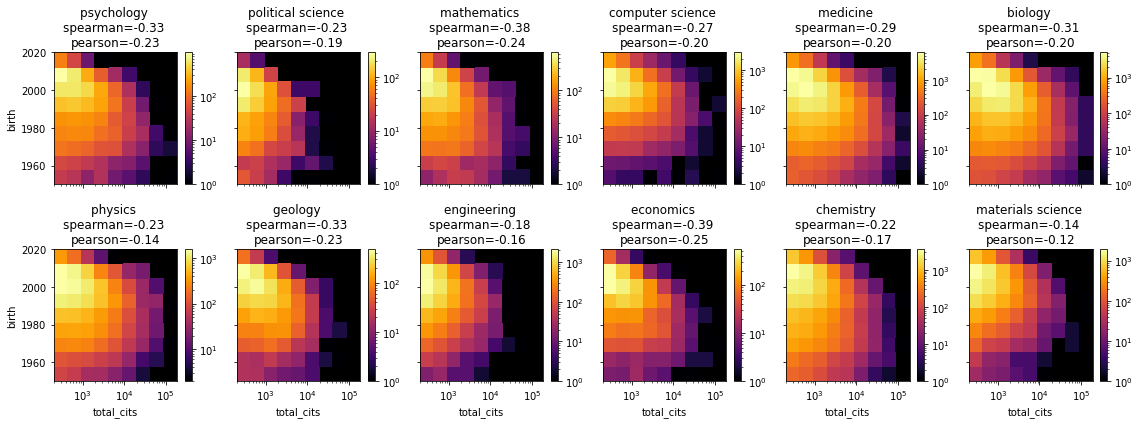

In [247]:
xbins = np.logspace(np.log10(min(data['total_cits'])), np.log10(max(data['total_cits'])+1), 10)
ybins = np.linspace(min(data['birth']), max(data['birth']), 10)
hist2d('total_cits', 'birth', xbins=xbins, ybins=ybins, xscale='log', yscale=None)

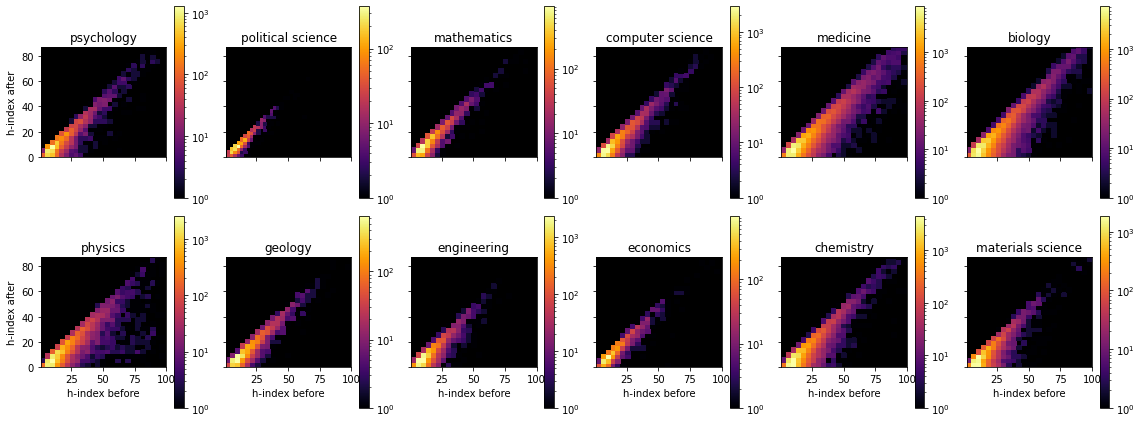

In [250]:
from s4_authors_stats import get_h_index

def _hindex_before_after(ax, group, field_name):
    valid_colabs_cit_list = group['colab_cit_list']
    valid_citation_list = group['cit_list']
    valid_h_index = group['hindex']
    hindex_after = []
    
    for ccits, acits in zip(valid_colabs_cit_list, valid_citation_list):
        diff_cits = json.loads(acits)
        for ctemp in json.loads(ccits):
            diff_cits.remove(ctemp)
        hafter = get_h_index(diff_cits)
        hindex_after.append(hafter)
    
    hindex_before_l1 = np.asarray([int(row[1:].split(',')[0]) for row in valid_h_index])
    hindex_after_l1 = np.asarray(hindex_after)[:,0]
    
    ax.set_facecolor("black")
    im = ax.hist2d(hindex_before_l1[hindex_before_l1 <= 100], hindex_after_l1[hindex_before_l1 <= 100], 
           norm=LogNorm(), cmap='inferno', bins=(25, 25))
    ax.set_aspect('equal')
    ax.set_title(field_name)
    
    return im, hindex_after 


def hindex_before_after():
    fig, axs = plt.subplots(figsize=(16, 6), nrows=2, ncols=6) #sharex=True, sharey=True)
    i = 0
    hafter_map = {}
    for field, group in data.groupby('fos'):
        if len(group) < 1000:
            continue
        ax = axs[int(i/6)][i%6]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im, hafter = _hindex_before_after(ax, group, field_name=field_name)
        hafter_map[field] = hafter
    
        if i%6 == 0: 
            ax.set_ylabel('h-index after')
        if int(i/6) == 1:    
            ax.set_xlabel('h-index before')
        
        fig.colorbar(im[3], ax=ax)
        
        i += 1
        
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_before_after.pdf')
    fig.show()
    
    return hafter_map

hafter_map = hindex_before_after()

100%|██████████| 14624/14624 [00:01<00:00, 7626.07it/s]


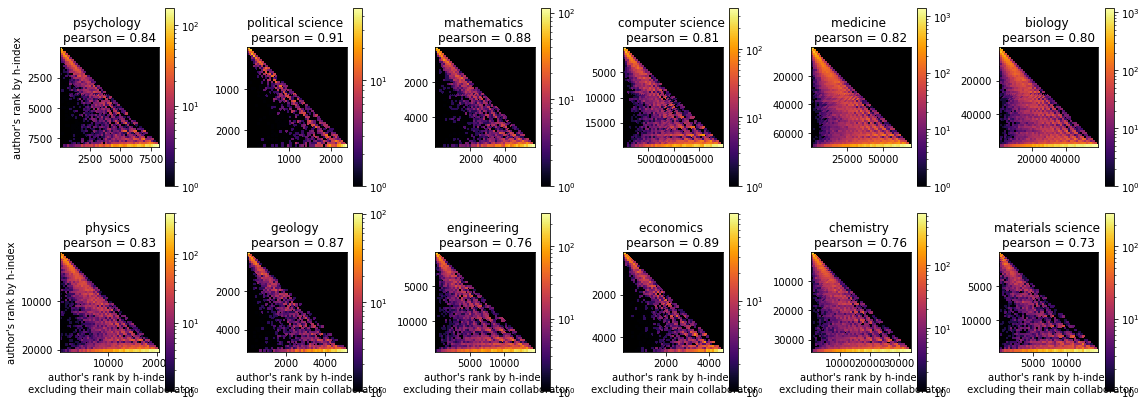

In [251]:
import tqdm

def rank(values, i, new_val):
    old = values[i]
    new_pair = np.array([(new_val[0], new_val[1], new_val[2], old[3])], dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

def get_rank_after(hindexbefore, i, ccits, acits):
    diff_cits = json.loads(acits)
    for ctemp in json.loads(ccits):
        diff_cits.remove(ctemp)
    hafter = get_h_index(diff_cits)
    rafter = rank(hindexbefore, i, (-hafter[0], -hafter[1], -hafter[2]))
    return rafter

def _plot_rank(ax, group, hindex_after, field_name):
    valid_h_index = [[int(temp) for temp in r[1:-1].split(',')] for r in group['hindex']]
    
    valid_colabs_cit_list = group['colab_cit_list']
    valid_citation_list = group['cit_list']
    
    neg_hindex = np.array([(-row[0], -row[1], -row[2], i) for i,row in enumerate(valid_h_index)], 
                          dtype=[('my_val1', int), ('my_val2', int), ('my_val3', int), ('my_val4', int)])
    neg_hindex_sorted = np.sort(neg_hindex)
    rankbefore = rankdata(neg_hindex, method='ordinal')

    results = []
    for a,b,c in tqdm.tqdm(zip(np.arange(len(neg_hindex)), valid_colabs_cit_list, valid_citation_list), total=len(neg_hindex)):
        results.append(get_rank_after(neg_hindex_sorted, a,b,c)) 
    
    ax.set_facecolor("black")
    ax.set_aspect('equal')
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im


def plot_rank(hafter_map):
    fig, axs = plt.subplots(figsize=(16, 6), nrows=2, ncols=6) # sharex=True, sharey=True)
    i = 0
    for field, group in data.groupby('fos'):
        if len(group) < 1000:
            continue
        ax = axs[int(i/6)][i%6]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _plot_rank(ax, group, hafter_map[field], field_name=field_name)
    
        if i%6 == 0: 
            ax.set_ylabel('author\'s rank by h-index')
        if int(i/6) == 1:    
            ax.set_xlabel('author\'s rank by h-index\n excluding their main collaborator')
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
        
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_hrank.pdf')
    fig.show()
    
plot_rank(hafter_map)
# from tqdm.auto import tqdm


100%|██████████| 14624/14624 [00:01<00:00, 11611.90it/s]


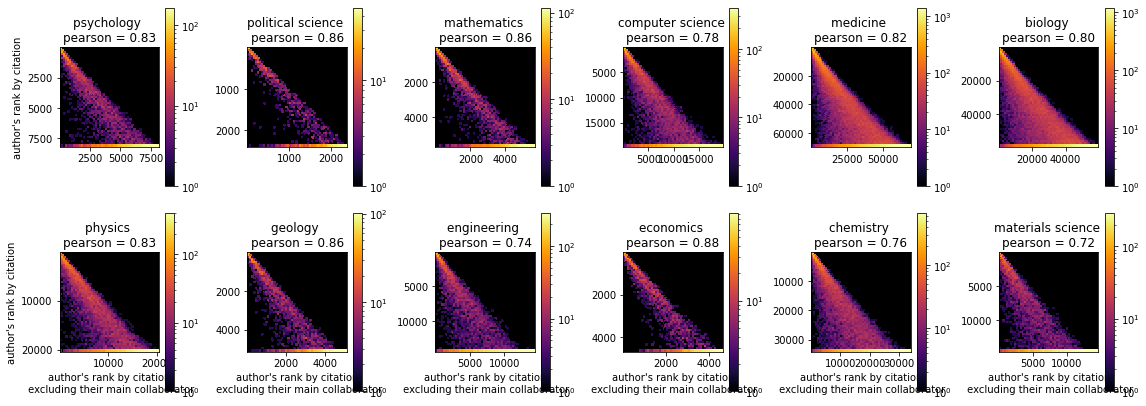

In [252]:

def rank_cits(values, i, new_val):
    old = values[i]
    new_pair = np.array([(new_val, old[1])], dtype=[('my_val1', int), ('my_val2', int)])
    new_rank = np.searchsorted(values, new_pair[0], side='right')
    return new_rank

    
def get_rank_after_cits(hindexbefore, i, ccits, acits):
    diff_cits = json.loads(acits)
    for ctemp in json.loads(ccits):
        diff_cits.remove(ctemp)
    hafter = - sum(diff_cits)
    rafter = rank_cits(hindexbefore, i, hafter)
    return rafter

def _plot_rank_cit(ax, group, field_name):
    
    colabs_cits = group['colab_cit_list']
    cits_list = group['cit_list']
    cits = group['total_cits']
    
    neg_hindex = np.array([(-row, i) for i,row in enumerate(cits)], dtype=[('my_val1', int), ('my_val2', int)])
    rankbefore = rankdata(neg_hindex, method='ordinal', axis=0)
    neg_hindex_sorted = np.sort(neg_hindex)
    
    results = []
    for a,b,c in tqdm.tqdm(zip(np.arange(len(neg_hindex)), colabs_cits, cits_list), total=len(neg_hindex)):
        results.append(get_rank_after_cits(neg_hindex_sorted, a,b,c)) 
    
    ax.set_facecolor("black")
    ax.set_aspect('equal')
    
    im = ax.hist2d(rankbefore, results, bins=50, cmap='inferno', norm=LogNorm())
    ax.set_title('%s \npearson = %.2f' % (field_name, pearsonr(rankbefore, results)[0]))
    ax.invert_yaxis()
    return im

    
def plot_rank_cits():
    fig, axs = plt.subplots(figsize=(16, 6), nrows=2, ncols=6) #sharex=True, sharey=True)
    i = 0
    for field, group in data.groupby('fos'):
        if len(group) < 1000:
            continue
        ax = axs[int(i/6)][i%6]
        
        field_name = fos_infos[fos_infos['field_id'] == field].iloc[0, -1]
        im = _plot_rank_cit(ax, group, field_name=field_name)
    
        if i%6 == 0: 
            ax.set_ylabel('author\'s rank by citation')
        if int(i/6) == 1:    
            ax.set_xlabel('author\'s rank by citation\n excluding their main collaborator')
    
        fig.colorbar(im[3], ax=ax)
        
        i += 1
        
    fig.tight_layout()
    fig.savefig('outputs/fos_hist2d_citrank.pdf')
    fig.show()

plot_rank_cits()